In [1]:
# IT5113 Programming for Data Science
# Final Project: Identifying Factors Affecting Business Demand
# Kolby DePron, 10/6/2026

In [2]:
from google.colab import files
uploaded = files.upload()


Saving US Superstore data.xls to US Superstore data.xls


In [3]:
import pandas as pd

df = pd.read_excel("US Superstore data.xls")

print(df.head())
print(df.info())


   Row ID        Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
1       2  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
2       3  CA-2016-138688 2016-06-12 2016-06-16    Second Class    DV-13045   
3       4  US-2015-108966 2015-10-11 2015-10-18  Standard Class    SO-20335   
4       5  US-2015-108966 2015-10-11 2015-10-18  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   South  FUR-BO-10

In [4]:
cols = ['Region', 'Segment', 'Category', 'Sales', 'Profit', 'Discount', 'Quantity']
df = df[cols].dropna()

print(df.shape)
print(df.head(3))
print(df.describe())
print(df['Region'].value_counts())


(9994, 7)
  Region    Segment         Category   Sales    Profit  Discount  Quantity
0  South   Consumer        Furniture  261.96   41.9136       0.0         2
1  South   Consumer        Furniture  731.94  219.5820       0.0         3
2   West  Corporate  Office Supplies   14.62    6.8714       0.0         2
              Sales       Profit     Discount     Quantity
count   9994.000000  9994.000000  9994.000000  9994.000000
mean     229.858001    28.656896     0.156203     3.789574
std      623.245101   234.260108     0.206452     2.225110
min        0.444000 -6599.978000     0.000000     1.000000
25%       17.280000     1.728750     0.000000     2.000000
50%       54.490000     8.666500     0.200000     3.000000
75%      209.940000    29.364000     0.200000     5.000000
max    22638.480000  8399.976000     0.800000    14.000000
Region
West       3203
East       2848
Central    2323
South      1620
Name: count, dtype: int64


In [5]:
from scipy.stats import ttest_ind

consumer = df[df['Segment'] == 'Consumer']['Sales']
corporate = df[df['Segment'] == 'Corporate']['Sales']

print("Group sizes: Consumer:", len(consumer), "Corporate:", len(corporate))

t_stat, p_val = ttest_ind(consumer, corporate, equal_var=False)
print(f"T-statistic = {t_stat:.3f}")
print(f"P-value = {p_val:.4f}")

if p_val < 0.05:
    print("Reject H0: There is a significant difference between Consumer and Corporate sales.")
else:
    print("Fail to reject H0: No significant difference in average sales.")


Group sizes: Consumer: 5191 Corporate: 3020
T-statistic = -0.742
P-value = 0.4583
Fail to reject H0: No significant difference in average sales.


In [6]:
# run t-test to see if segments differ in sales
def compare_segment_sales(df):
    """
    Runs a two-sample t-test to compare average sales between
    'Consumer' and 'Corporate' segments.

    Args:
        df (pd.DataFrame): Cleaned dataset with 'Segment' and 'Sales' columns.

    Returns:
        dict: A dictionary containing the t-statistic, p-value, and a short decision message.
    """

    # make sure required columns are present
    assert 'Segment' in df.columns and 'Sales' in df.columns, "Missing required columns"

    # separate the two segment groups
    consumer = df[df['Segment'] == 'Consumer']['Sales']
    corporate = df[df['Segment'] == 'Corporate']['Sales']

    # run the Welch's t-test (does not assume equal variances)
    t_stat, p_val = ttest_ind(consumer, corporate, equal_var=False)

    # print test results
    print(f"T-statistic = {t_stat:.3f}, P-value = {p_val:.4f}")

    # interpret result using alpha = 0.05
    if p_val < 0.05:
        decision = "Reject H₀ → There is a significant difference in sales between segments."
    else:
        decision = "Fail to reject H₀ → No significant difference found."

    # return the results so they can be used later
    return {"t_stat": t_stat, "p_val": p_val, "decision": decision}
    print(decision)



In [7]:
# check if sales are different across regions
def test_sales_by_region(df):
    """
    Test if sales are different across regions using ANOVA.
    """

    # make sure we have what we need
    assert 'Region' in df.columns and 'Sales' in df.columns, "Missing columns"

    # make groups for each region
    east = df[df['Region'] == 'East']['Sales']
    west = df[df['Region'] == 'West']['Sales']
    central = df[df['Region'] == 'Central']['Sales']
    south = df[df['Region'] == 'South']['Sales']

    # run the ANOVA test
    from scipy.stats import f_oneway
    f_stat, p_val = f_oneway(east, west, central, south)

    # print results so I can see them
    print(f"F = {f_stat:.3f}, p = {p_val:.4f}")

    # check if p < 0.05
    if p_val < 0.05:
        print("Reject H0 → At least one region has different average sales.")
    else:
        print("Fail to reject H0 → Sales look similar across regions.")

    return f_stat, p_val


In [8]:
# check how discount affects profit
def check_discount_profit(df):
    """Run a quick linear regression to see if discounts affect profit."""

    # make sure we don't have missing values
    df = df.dropna(subset=['Discount', 'Profit'])

    # set up the data
    X = df[['Discount']]
    y = df['Profit']

    # make the model and fit it
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(X, y)

    # get results
    coef = model.coef_[0]
    intercept = model.intercept_
    r2 = model.score(X, y)

    # print results in a simple way
    print("Coefficient:", round(coef, 3))
    print("Intercept:", round(intercept, 3))
    print("R²:", round(r2, 3))

    # quick interpretation
    if coef < 0:
        print("As discount increases, profit goes down.")
    else:
        print("As discount increases, profit goes up.")

    return coef, intercept, r2


In [9]:
def main():
    """Run all analyses and print summaries."""
    print("1️) Comparing sales by segment:")
    seg_results = compare_segment_sales(df)

    print("\n2️) Testing regional differences:")
    reg_results = test_sales_by_region(df)

    print("\n3️) Checking discount–profit relationship:")
    reg_model = check_discount_profit(df)

    print("\nDone. See printed results for interpretation.")


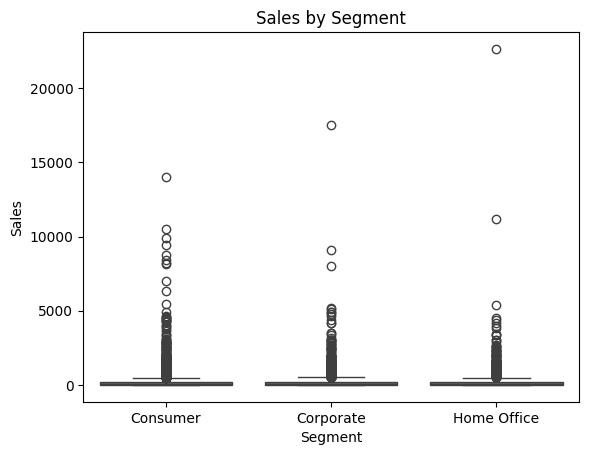

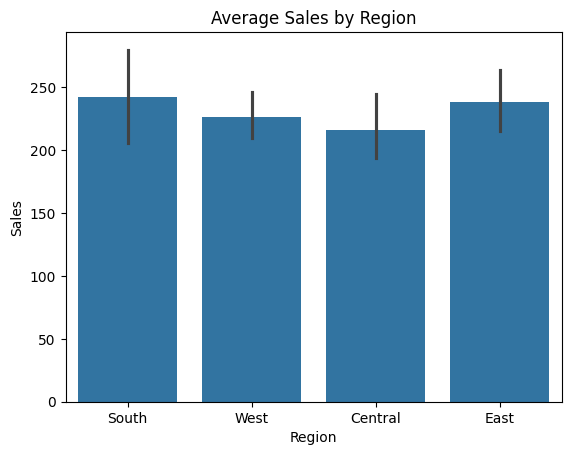

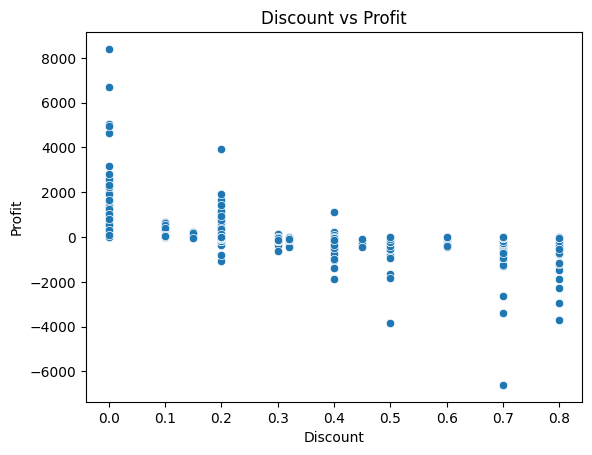

In [10]:
# These are vizualizaton for my project report


import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='Segment', y='Sales', data=df)
plt.title('Sales by Segment')
plt.show()

sns.barplot(x='Region', y='Sales', data=df, estimator='mean')
plt.title('Average Sales by Region')
plt.show()

sns.scatterplot(x='Discount', y='Profit', data=df)
plt.title('Discount vs Profit')
plt.show()


In [11]:
# run all tests and print summaries

def main():
    """Run all analyses and print results in order."""

    print("Comparing sales by segment:")
    compare_segment_sales(df)

    print("\nTesting regional differences:")
    test_sales_by_region(df)

    print("\nChecking discount-profit relationship:")
    check_discount_profit(df)

    print("\nAnalysis complete. See printed results above.")

main()

Comparing sales by segment:
T-statistic = -0.742, P-value = 0.4583

Testing regional differences:
F = 0.801, p = 0.4933
Fail to reject H0 → Sales look similar across regions.

Checking discount-profit relationship:
Coefficient: -249.051
Intercept: 67.559
R²: 0.048
As discount increases, profit goes down.

Analysis complete. See printed results above.
